# AM 115: Mathematical Modeling
### Final Project: Shirley Wang

#### Aim 2: Formalize group-level theory 

<img src="images/mod2.png" style="width: 600px;">

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def mod2(t, y_vec, a1, b1, b2, c1, c2, c3):
    '''
    vars:
        H: healty population without mental disorder or suicidal thoughts 
        M: population with mental disorder and NO suicidal thoughts
        S: population with suicidal thoughts 
        D: died by suicide
    
    args:
        a1: rate of healthy --> mental disorder
        b1: rate of mental disorder --> suicidal
        b2: rate of mental disorder --> healthy ('recovery rate')
        c1: rate of suicidal --> died by suicide ('lethal attempt rate')
        c2: rate of suicidal --> mental disorder ('recovery from STBs rate')
    '''
    H = y_vec[0]
    M = y_vec[1]
    S = y_vec[2]
    D = y_vec[3]
    
    N = H + M + S + D # total population
    
    dH = -(a1/N)*H*M + b2*M + c3*S
    dM = (a1/N)*H*M - (b1/N)*M*S - b2*M + c2*S
    dS = (b1/N)*M*S - c1*S - c2*S - c3*S
    dD = c1*S
    
    return(dH, dM, dS, dD)

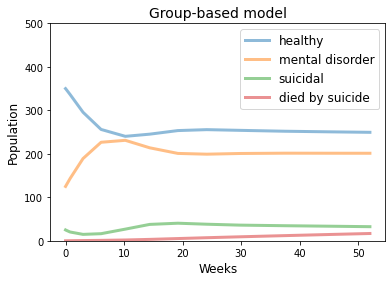

In [527]:
# initial conditions 
n = 500
y_vec = np.array([int(n*0.7), int(n*0.25), int(n*.05), 0])

# parameters
a1 = 0.7
b1 = 2.0
b2 = 0.3
c1 = 0.01
c2 = 0.5
c3 = 0.3

# integrate 
sol_1 = solve_ivp(mod2, [0, 52], y_vec, args = (a1, b1, b2, c1, c2, c3))

# plot
plt.figure(figsize=(6, 4))
plt.plot(sol_1.t, sol_1.y[0, :], label = 'healthy', linewidth = 3, alpha = 0.5)
plt.plot(sol_1.t, sol_1.y[1, :], label = 'mental disorder', linewidth = 3, alpha = 0.5)
plt.plot(sol_1.t, sol_1.y[2, :], label = 'suicidal', linewidth = 3, alpha = 0.5)
plt.plot(sol_1.t, sol_1.y[3, :], label = 'died by suicide', linewidth = 3, alpha = 0.5)
plt.legend(loc = 'upper right', fontsize = 12)
plt.title('Group-based model', fontsize = 14)
plt.ylabel('Population', fontsize = 12)
plt.xlabel('Weeks', fontsize = 12)
plt.ylim([0, n])
plt.savefig("images/group_diffeq.png", dpi = 300);

## Individual Agent Model

In [306]:
def simulate1D(n, nc, pHM, pMS, pSD, pMH, pSM, pSH):
    
    t = 0
    pop = initial1D(int(n*0.7), int(n*0.25), int(n*.05), 0)
    H, M, S, D = census1D(pop)
    results = [[H, M, S, D]]
    tt = [t]
    
    for j in range(52):
        pop = suicidespread(nc, pHM, pMS, pSD, pMH, pSM, pSH, pop)
        H, M, S, D = census1D(pop)
        results.append([H, M, S, D])
        t = t+1
        tt.append(t)
    
    return tt, results

In [307]:
def initial1D(H0, M0, S0, D0):
    
    # sets initial population vector
    # each subpopulation is appended to ghe growing vector
    
    pop = []
    for i in range(H0):
        pop.append('H')
    for i in range(M0):
        pop.append('M')
    for i in range(S0):
        pop.append('S')
    for i in range(D0):
        pop.append('D')
    
    return pop

In [308]:
def census1D(pop):
    
    # counts the number of H, M, S, D cells in population
    
    H = 0
    M = 0
    S = 0
    D = 0
    N = np.array(pop).shape[0]
    
    for j in range(N):
        if pop[j] == 'H':
            H += 1
        if pop[j] == 'M':
            M += 1
        if pop[j] == 'S':
            S += 1
        if pop[j] == 'D':
            D += 1
    
    return H, M, S, D

In [431]:
def suicidespread(nc, pHM, pMS, pSD, pMH, pSM, pSH, pop1):
    
    # stochastic 'suicide epidemic' simulation calculates a new pop2 vector
    
    pop2 = pop1.copy()
    N = np.array(pop1).shape[0]
    
    for j in range(N):
        if pop1[j] == 'M':
            if np.random.rand() < pMH:
                pop2[j] = 'H'
            else:
                for c in range(nc):
                    k = j
                    while k == j:
                        k = np.random.randint(n)
                    if pop1[k] == 'H' and np.random.rand() < pHM:
                        pop2[k] = 'M'
                    elif pop1[k] == 'S' and np.random.rand() < pMS:
                        pop2[j] = 'S'
            
        elif pop1[j] == 'S':
            r = np.random.rand()
            if r < pSM:
                pop2[j] = 'M'
            elif (r > pSM) & (r < pSM + pSD):
                pop2[j] = 'D'
            elif (r > pSM + pSD) & (r < pSM + pSD + pSH):
                pop2[j] = 'H'
    return pop2

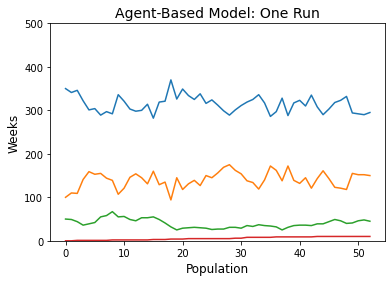

In [535]:
n = 500
nc = 20
pHM = 0.4
pMS = 0.3
pMH = 0.8
pSM = 0.2
pSD = 0.005
pSH = 0.05

tt, results = simulate1D(n, nc, pHM, pMS, pSD, pMH, pSM, pSH)
plt.figure()
plt.plot(tt, results)
plt.title('Agent-Based Model: One Run', size = 14)
plt.ylabel('Weeks', size = 12)
plt.xlabel('Population', size = 12)
plt.ylim([0, n])
plt.savefig("images/group_agent1.png", dpi = 300);

### Individual Agent: Multiple Runs

Note: code with much help from Laura in office hours! Thank you Laura! 

In [530]:
Nr = 20                    # number of simulations 
Nt = 53                    # number of max time steps 
X1 = np.zeros([Nr, 5, Nt])  # simulation 
X1[:] = np.nan  

# loop over the number of simulations 
for ii in range(Nr): 
    t1, results1 = simulate1D(n, nc, pHM, pMS, pSD, pMH, pSM, pSH)  # one run 
    
    X1[ii, 0, 0:len(t1)] = t1
    X1[ii, 1, 0:len(t1)] = [results1[ii][0] for ii in range(len(results1))] 
    X1[ii, 2, 0:len(t1)] = [results1[ii][1] for ii in range(len(results1))] 
    X1[ii, 3, 0:len(t1)] = [results1[ii][2] for ii in range(len(results1))] 
    X1[ii, 4, 0:len(t1)] = [results1[ii][2] for ii in range(len(results1))]

In [531]:
t1 = np.nanmean(X1[:, 0, :], axis = 0)
H1 = np.nanmean(X1[:, 1, :], axis = 0)
M1 = np.nanmean(X1[:, 2, :], axis = 0)
S1 = np.nanmean(X1[:, 3, :], axis = 0)
D1 = np.nanmean(X1[:, 4, :], axis = 0)
H1_v = np.sqrt(np.nanvar(X1[:, 1, :], axis = 0))
M1_v = np.sqrt(np.nanvar(X1[:, 2, :], axis = 0))
S1_v = np.sqrt(np.nanvar(X1[:, 3, :], axis = 0))
D1_v = np.sqrt(np.nanvar(X1[:, 4, :], axis = 0))

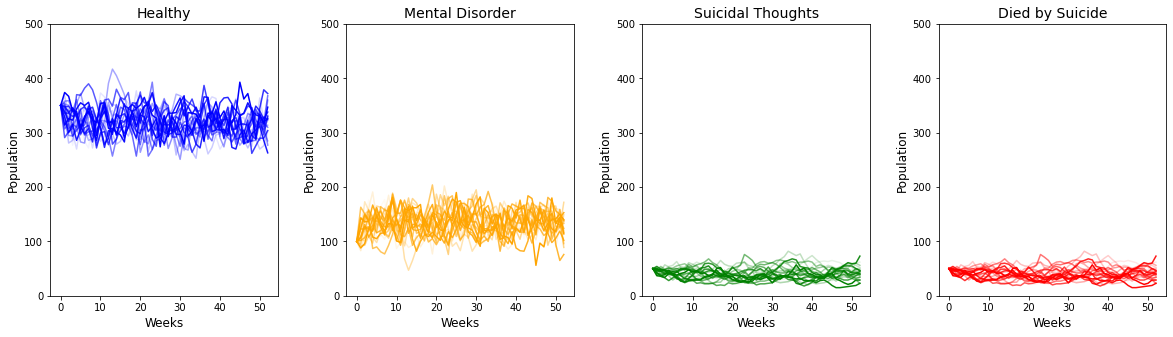

In [537]:
# plotting all the runs for simulation 1 

fig, ax = plt.subplots(1, 4, figsize = (20, 5))
N = 20

for ii in range(N): 
    ax[0].plot(X1[ii, 0, :], X1[ii, 1, :], 'blue', alpha = 1 - (1./N* ii))
    ax[0].set_title('Healthy', size = 14)
    ax[0].set_ylim([0, n])

    ax[1].plot(X1[ii, 0, :], X1[ii, 2, :], 'orange', alpha = 1 - (1./N* ii))
    ax[1].set_title('Mental Disorder', size = 14)
    ax[1].set_ylim([0, n])

    ax[2].plot(X1[ii, 0, :], X1[ii, 3, :], 'green', alpha = 1 - (1./N* ii))
    ax[2].set_title('Suicidal Thoughts', size = 14)
    ax[2].set_ylim([0, n])
    
    ax[3].plot(X1[ii, 0, :], X1[ii, 4, :], 'red', alpha = 1 - (1./N* ii))
    ax[3].set_title('Died by Suicide', size = 14)
    ax[3].set_ylim([0, n])
    
for ii in range(4): 
    ax[ii].set_xlabel('Weeks', size = 12)
    ax[ii].set_ylabel('Population', size = 12)

plt.subplots_adjust(wspace=0.3)

plt.savefig("images/group_agent_multi.png", dpi = 300);

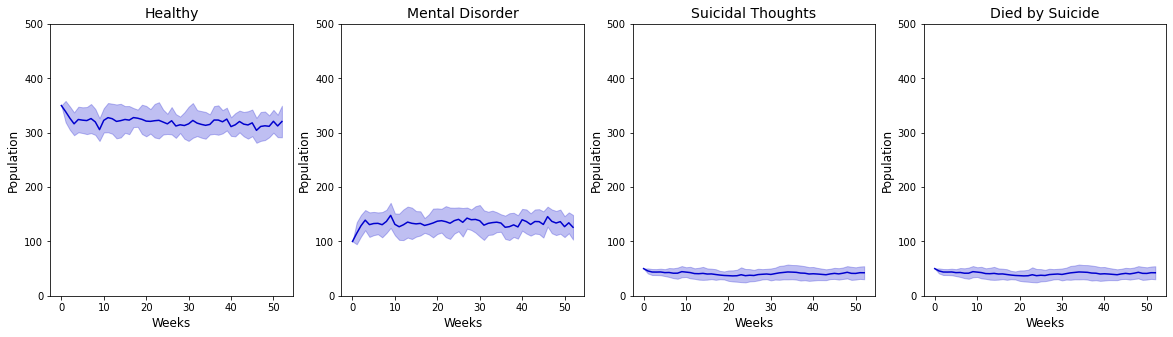

In [538]:
# with error bars
fig, ax = plt.subplots(1, 4, figsize = (20, 5))
a_val = 0.25

ax[0].plot(t1, H1, color='mediumblue')
ax[0].fill_between(t1, (H1 + H1_v), (H1 -  H1_v), color='mediumblue', alpha=a_val)
ax[0].set_ylim([0, n])
ax[0].set_title('Healthy', size = 14)

ax[1].plot(t1, M1, color='mediumblue')
ax[1].fill_between(t1, (M1 + M1_v), (M1 - M1_v), color='mediumblue', alpha=a_val)
ax[1].set_ylim([0, n])
ax[1].set_title('Mental Disorder', size = 14)

ax[2].plot(t1, S1, color='mediumblue', label = 'nc = 20, pt = 0.1')
ax[2].fill_between(t1, (S1 + S1_v), (S1 - S1_v), color='mediumblue', alpha=a_val)
ax[2].set_ylim([0, n])
ax[2].set_title('Suicidal Thoughts', size = 14)

ax[3].plot(t1, S1, color='mediumblue', label = 'nc = 20, pt = 0.1')
ax[3].fill_between(t1, (S1 + S1_v), (S1 - S1_v), color='mediumblue', alpha=a_val)
ax[3].set_ylim([0, n])
ax[3].set_title('Died by Suicide', size = 14)

for ii in range(4): 
    ax[ii].set_xlabel('Weeks', size = 12)
    ax[ii].set_ylabel('Population', size = 12)
    
plt.savefig("images/group_agent_error.png", dpi = 300);